# バンディット問題の戦略別パフォーマンス比較

### 概要
ベーシックな多腕バンディット問題に対して、下記それぞれの戦略での結果を比較する。
1. 完全ランダム
2. Greedy
3. ε-Greedy (εは適当に定める)
4. UCT

### 参考
https://zenn.dev/5nta/articles/78361b28d414b54df29b

In [675]:
from numpy.random import binomial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm import tqdm

### アーム

In [56]:
# p: 成功確率
class Arm:
    def __init__(self, p):
        self._p = p
        self.success = 0
        self.fail = 0

    def play(self):
        result = binomial(n=1, p=self._p)
        if result == 1:
            self.success += 1
        else:
            self.fail += 1
        return result
    
    def visits(self):
        return self.success + self.fail
    
    def success_ratio(self):
        if self.visits() == 0:
            return 0
        return self.success / self.visits()

## 各アルゴリズムの実装

In [57]:
def calc_success_ratio(arm):
    if arm.success + arm.fail == 0:
        return 0
    return arm.success / (arm.success + arm.fail)

In [659]:
class Player:
    def __init__(self, p_list, n_list, T, method, epsilon=0.1):
        self.arms = []
        self.n_list = n_list
        self.p_list = p_list
        for p, n in zip(p_list, n_list):
            for _ in range(n):
                self.arms.append(Arm(p))
        self.t = 0
        self.T = T
        self.sum_reward = 0
        self.method = method
        self.greedy_trial = 1
        self.epsilon = epsilon
        self.N = sum(n_list)
        self.mean_rewards = []
        
    def init(self):
        self.arms = []
        for p, n in zip(self.p_list, self.n_list):
            for _ in range(n):
                self.arms.append(Arm(p))
        self.t = 0
        self.T = self.T
        self.sum_reward = 0
        self.method = self.method
        self.greedy_trial = 1
        self.epsilon = self.epsilon
        self.N = sum(self.n_list)    
        self.mean_rewards = []
        
    def execute(self):
        while self.t < self.T:
            self.play()
        return self.mean_rewards[-1]
        
    def play(self):
        selected_idx = eval("self." + self.method)()
        self.sum_reward += self.arms[selected_idx].play()
        if len(self.mean_rewards) == 0:
            self.mean_rewards = [self.sum_reward/ (self.t + 1)]
        else:
            self.mean_rewards.append(self.sum_reward / (self.t + 1))
        # print(self.mean_rewards)
        self.t += 1
    
    def random(self):
        idx = np.random.randint(0,self.N)
        return idx
    
    def greedy(self):
        if self.t < self.N * self.greedy_trial:
            idxs = [i for i, arm in enumerate(self.arms) if arm.visits() < self.greedy_trial]
            return np.random.choice(idxs)
        else:
            return self.select_best_arm()
    
    def epsilon_greedy(self):
        if self.t < self.N * self.greedy_trial:
            idxs = [i for i, arm in enumerate(self.arms) if arm.visits() < self.greedy_trial]
            return np.random.choice(idxs)
        else:
            if binomial(n=1, p=self.epsilon) == 1:
                # 探索ステップ : アームを一様ランダムに選ぶ
                idx = np.random.randint(0,self.N)
                return idx
            else:
                return self.select_best_arm()
            
    def ucb(self):
        if self.t < self.N:
            idxs = [i for i, arm in enumerate(self.arms) if arm.visits() < 1]
            return np.random.choice(idxs)
        else:
            avgs = [ self.calc_ucb(arm) for arm in self.arms]
            idx = avgs.index(max(avgs))
            return idx
        
    def select_best_arm(self):
        avgs = [ arm.success_ratio() for arm in self.arms]
        idx = avgs.index(max(avgs))
        return idx
    
    def calc_ucb(self, arm):
        ucb = arm.success_ratio() + math.sqrt(2*math.log(self.t) /arm.visits())
        return ucb

In [660]:
p_list = [0.1, 0.2, 0.3, 0.4]
n_list = [1, 1, 1, 1]
T = 10000

In [661]:
def calc_performance(player, n =50):
    score_list = []
    sum_score = 0
    for i in tqdm(range(n)):
        score = player.execute()
        sum_score += score
        # print(score)
        score_list.append(player.mean_rewards)
        player.init()
     #    print(player.mean_rewards)
#         print(score_list)
    # print(sum_score / n)
    return score_list

In [663]:
player = Player(p_list, n_list, T , "random")
random_results = calc_performance(player)

100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


In [653]:
player = Player(p_list, n_list, T, "greedy")
greedy_results = calc_performance(player)

100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


In [657]:
player = Player(p_list, n_list, T, "epsilon_greedy", epsilon=0.2)
eps_greedy_results = calc_performance(player)

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


In [655]:
player = Player(p_list, n_list, T, "ucb")
ucb_results = calc_performance(player)

100%|██████████| 50/50 [00:14<00:00,  3.41it/s]


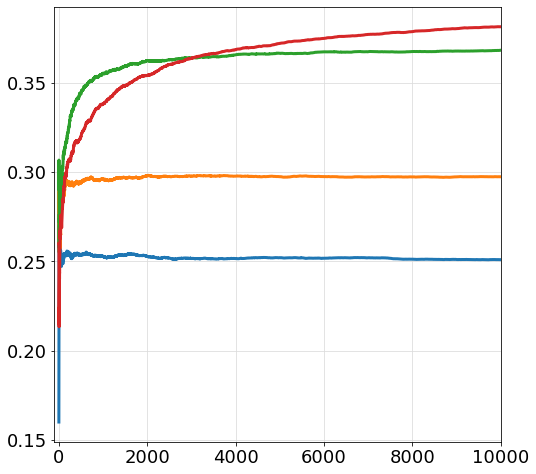

In [701]:
plt.rcParams["font.size"] = 18
plt.figure(figsize=(8, 8))
plt.plot(np.mean(np.array(random_results), axis=0), label='random', linewidth=3)
plt.plot(np.mean(np.array(greedy_results), axis=0), label = 'greedy', linewidth=3)
plt.plot(np.mean(np.array(eps_greedy_results), axis=0), label = 'ε-greedy', linewidth=3)
plt.plot(np.mean(np.array(ucb_results), axis=0), label='ucb', linewidth=3)
plt.xlim((-100,10000))
plt.grid(c='gainsboro')
plt.savefig('bandit_result.png')
# plt.legend()

In [620]:
num_sims = 1000
times = np.zeros(num_sims * T)
rewards = np.zeros(num_sims * T)
for sim in range(num_sims):
    for t in range(T):
        index = sim * T + t
        times[index] = t+1
        rewards[index] = greedy_results[sim][t]

In [621]:
df_result = pd.DataFrame({"times": times, "rewards":rewards})

In [622]:
grouped = df_result['rewards'].groupby(df_result["times"])

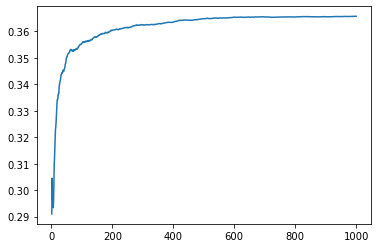

In [625]:
plt.plot(grouped.mean(), label='ucb1')

In [519]:
player = Player(p_list, n_list, T, "greedy")
calc_performance(player)

100%|██████████| 100/100 [00:23<00:00,  4.23it/s]

0.36278299999999997


In [514]:
player = Player(p_list, n_list, T, "epsilon_greedy", epsilon=0.1)
calc_performance(player)

100%|██████████| 100/100 [00:03<00:00, 30.59it/s]

0.45445


In [515]:
player = Player(p_list, n_list, T, "epsilon_greedy", epsilon=0.2)
calc_performance(player)

100%|██████████| 100/100 [00:03<00:00, 30.26it/s]

0.4430300000000001


In [520]:
player = Player(p_list, n_list, T, "ucb")
calc_performance(player)

100%|██████████| 100/100 [00:31<00:00,  3.22it/s]

0.476989


In [350]:
for arm in player.arms:
    print(arm._p, arm.visits())

0.1 23
0.3 38
0.5 139
0.7 355
0.9 9445


### ランダム

epsilon_greedyのepsilon = 1での実行と同義なので実装省略

### Greedy

In [71]:
def greedy(arms, T, n=10):
    reward = 0
    t = 0
    for arm in arms:
        for i in range(10):
            reward += arm.play()
            t += 1
    while t < T:
        avgs = [ calc_success_ratio(arm) for arm in arms]
        index = avgs.index(max(avgs))
        t += 1
        reward += arms[index].play()
    return reward
    

### ε-Greedy

In [61]:
from numpy.random import binomial, randint
# from Arm import Arm

def epsilon_greedy(arms, T, epsilon):
    reward = 0
    for i in range(T):
        if binomial(n=1, p=epsilon) == 1:
            # 探索ステップ : アームを一様ランダムに選ぶ
            index = randint(0, len(arms))
        else:
            # 活用ステップ : 今までで一番成功確率の高いアームを選ぶ
            avgs = [ calc_success_ratio(arm) for arm in arms]
            index = avgs.index(max(avgs))
        reward += arms[index].play()
    return reward

### UCB

In [207]:
def get_ucb(arm, t):
    ucb = arm.success / (arm.success + arm.fail) + math.sqrt(2*math.log(t) / (arm.success + arm.fail))
    return  ucb

def UCB(arms, T):
    reward = 0
    t = 0
    for arm in arms:
        reward += arm.play()
        t += 1
    while t < T:
        scores = [get_ucb(arm, t) for arm in arms]
        max_score_index = scores.index(max(scores))
        reward += arms[max_score_index].play()
        t += 1
    return reward

## 比較実験
下記の設定でMulti-Armを用意する。  
p=0.3を5本, p=0.4を5本, p=0.5を4本, p=0.6を1本

In [287]:
p_list = [0.1, 0.15]
n_list = [9, 1]
T = 10000

In [288]:
def init_multi_arms(p_list, n_list):
    arms = []
    for p, n in zip(p_list, n_list):
        for _ in range(n):
            arms.append(Arm(p))
    return arms

### ランダム

In [295]:
initial_arms = init_multi_arms(p_list, n_list)
epsilon_greedy(initial_arms, T, 1.0)

1089

### greedy

In [305]:
initial_arms = init_multi_arms(p_list, n_list)
greedy(initial_arms, T, n=5)

1495

### ε-Greedy

In [269]:
initial_arms = init_multi_arms(p_list, n_list)
epsilon_greedy(initial_arms, T, 0.05)

6842

### UCB

In [315]:
initial_arms = init_multi_arms(p_list, n_list)
UCB(initial_arms, T)

1109

In [284]:
sum = 0
for arm in initial_arms:
    print(arm._p, end = '  ')
    play_num = arm.success + arm.fail
    print(play_num)
    sum += play_num
print(sum)

0.1  28
0.1  41
0.1  35
0.1  30
0.1  28
0.1  25
0.1  23
0.1  25
0.1  28
0.1  28
0.2  30
0.2  53
0.2  39
0.2  46
0.2  56
0.2  44
0.2  35
0.2  35
0.2  35
0.2  48
0.3  63
0.3  46
0.3  37
0.3  44
0.3  56
0.3  41
0.3  70
0.3  39
0.3  56
0.3  49
0.4  72
0.4  70
0.4  81
0.4  98
0.4  58
0.4  87
0.4  81
0.4  73
0.4  108
0.4  80
0.5  133
0.5  121
0.5  175
0.5  75
0.5  149
0.5  103
0.5  106
0.5  111
0.5  75
0.5  113
0.6  227
0.6  274
0.6  188
0.6  246
0.6  169
0.6  181
0.6  126
0.6  189
0.6  147
0.6  239
0.7  348
0.7  423
0.7  371
0.7  637
0.7  311
0.7  494
0.7  407
0.7  465
0.7  547
0.7  829
10000


In [286]:
sum = 0
for arm in initial_arms:
    print(arm._p, end = '  ')
    play_num = arm.success + arm.fail
    print(play_num)
    sum += play_num
print(sum)

0.1  10
0.1  10
0.1  10
0.1  10
0.1  10
0.1  10
0.1  10
0.1  10
0.1  10
0.1  10
0.2  10
0.2  10
0.2  10
0.2  10
0.2  10
0.2  10
0.2  10
0.2  10
0.2  10
0.2  10
0.3  10
0.3  10
0.3  10
0.3  10
0.3  10
0.3  10
0.3  10
0.3  10
0.3  10
0.3  10
0.4  10
0.4  10
0.4  10
0.4  10
0.4  10
0.4  10
0.4  10
0.4  10
0.4  10
0.4  10
0.5  10
0.5  10
0.5  10
0.5  10
0.5  10
0.5  10
0.5  10
0.5  11
0.5  10
0.5  10
0.6  21
0.6  10
0.6  10
0.6  10
0.6  13
0.6  10
0.6  12
0.6  16
0.6  10
0.6  10
0.7  11
0.7  10
0.7  13
0.7  91
0.7  22
0.7  9189
0.7  10
0.7  11
0.7  10
0.7  10
10000
